In [142]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from pytorch3d.transforms import quaternion_to_matrix

In [143]:
import pickle
import sys
import time 

def tic():
  return time.time()
def toc(tstart, nm=""):
  print('%s took: %s sec.\n' % (nm,(time.time() - tstart)))

def read_data(fname):
  d = []
  with open(fname, 'rb') as f:
    if sys.version_info[0] < 3:
      d = pickle.load(f)
    else:
      d = pickle.load(f, encoding='latin1')  # needed for python 3
  return d

suite = "trainset"
dataset = '1'

cfile = f"../data/{suite}/cam/cam{dataset}.p"
ifile = f"../data/{suite}/imu/imuRaw{dataset}.p"
vfile = f"../data/{suite}/vicon/viconRot{dataset}.p"

ts = tic()
camd = read_data(cfile)
imud = read_data(ifile)
# vicd = read_data(vfile)
Q = torch.load(f"{dataset}_best_gd_Q.pt")
toc(ts,"Data import")

Data import took: 1.3638174533843994 sec.



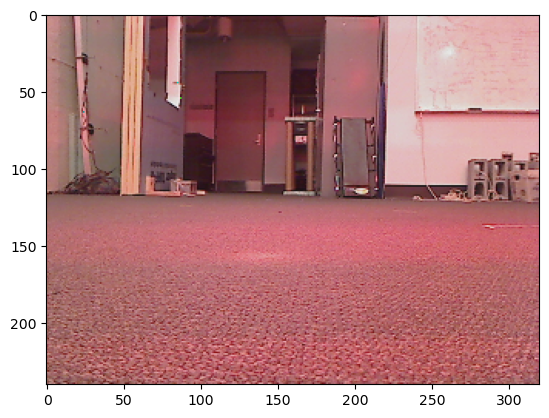

In [144]:
plt.imshow(camd['cam'][:,:,:,0])

In [145]:
# T = vicd['ts'][0]
# R = vicd['rots'].transpose(2,0,1)

T = imud['ts'][0] 
R = quaternion_to_matrix(Q).detach().numpy()

rotation_index_per_image = np.searchsorted(T, camd['ts'][0])
image_end = -len(rotation_index_per_image[rotation_index_per_image==T.shape[0]])
rotation_index_per_image -= 1

In [146]:
N_radius = 306
N_circumference = 1923

# def build_cartesian__coords(N_radius):
cam_x_range = (math.pi/6, -math.pi/6)
cam_x_size = 320
cam_y_range = (math.pi/8, -math.pi/8)
cam_y_size = 240

cam_x, cam_y = np.meshgrid(
    np.linspace(cam_y_range[0], cam_y_range[1], cam_y_size), 
    np.linspace(cam_x_range[0], cam_x_range[1], cam_x_size))
spherical_coords = np.stack([cam_y.transpose(), cam_x.transpose()], axis=-1)

cartesian_coords = np.empty((240, 320, 3))
def spherical_to_cartesian(s_coord):
    return np.array([math.cos(s_coord[1])*math.cos(s_coord[0]), math.cos(s_coord[1])*math.sin(s_coord[0]), math.sin(s_coord[1])])

# Iterate over each element
for i in range(spherical_coords.shape[0]):
    for j in range(spherical_coords.shape[1]):
        cartesian_coords[i, j] = spherical_to_cartesian(spherical_coords[i, j, :])
cartesian_coords = cartesian_coords*N_radius

def rotate_and_map(cartesian_coords, images, Rs):
    result = np.zeros([2*N_radius,N_circumference,3], dtype=int)
    for (image, R) in tqdm(zip(images, Rs)):
        # Reshape coords for matrix multiplication
        flatten_coords = cartesian_coords.reshape(-1, 3)
        flatten_image  = image.reshape(-1, 3)
        rotated_coords = np.dot(flatten_coords, R.T)

        theta = np.arctan2(rotated_coords[:, 1], rotated_coords[:, 0])
        theta_index = np.round(N_circumference / 2 - N_radius * theta) % N_circumference
        theta_index = theta_index.astype(int)
        
        z = rotated_coords[:, 2]
        z_index = np.round(N_radius - z) % (2 * N_radius)
        z_index = z_index.astype(int)

        result[z_index, theta_index, :] = flatten_image
    return result

In [147]:
camd['cam'].shape

(240, 320, 3, 1685)

800it [00:02, 282.34it/s]


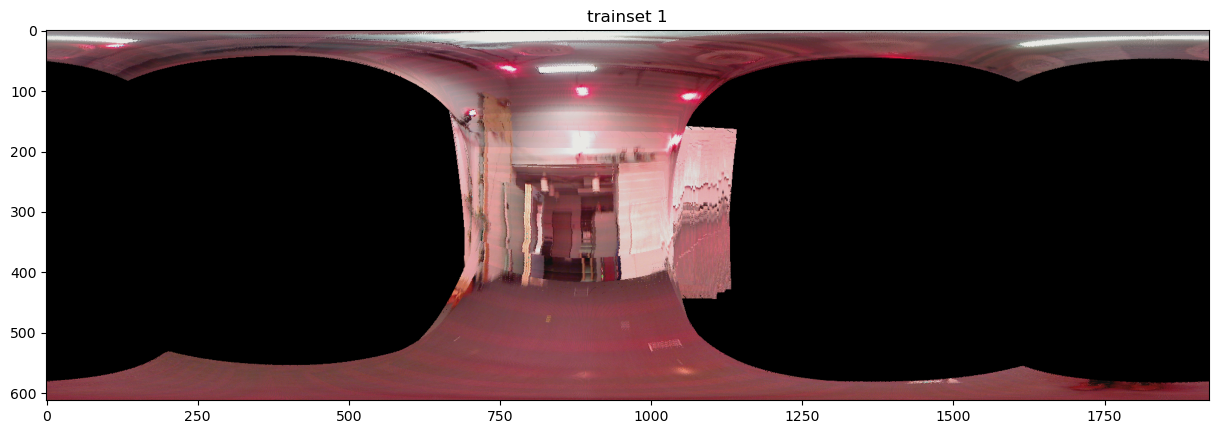

In [149]:
def plot(start_img_idx=0, end_img_idx=-1):
    cylinder_map = rotate_and_map(cartesian_coords,
                              camd['cam'].transpose(3,0,1,2)[start_img_idx:end_img_idx],
                              R[rotation_index_per_image,:,:][start_img_idx:end_img_idx])

    plt.figure(figsize=(15, 6))  # Adjust these values as needed
    plt.imshow(cylinder_map)
    plt.title(f"{suite} {dataset}")
    plt.show()

plot(0,800)